# Análise do uso das redes sociais pelas candidaturas

[Voltar ao Índice](00_indice.ipynb)

Vamos realizar uma análise de estatística descritiva dos dados do TSE referentes ao uso de redes sociais pelas candidaturas. 
O objetivo é ter um panorama de quais são as redes sociais e recursos da web utilizados pelas candidaturas e as relações entre
esse uso e características das candidaturas.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import scipy.stats as stats
import numpy as np
from importlib import reload

import src.analysis_functions as af
import xavy.dataframes as xd
import xavy.stats as xx
import xavy.plots as xp

## Carregando os dados

Vamos produzir uma tabela com uma linha por candidato mostrando quais as plataformas utilizadas por cada um. Também vamos juntar a cada candidato diversas características suas e do eleitorado da sua unidade.

In [2]:
# Carrega informações sobre o candidato, seus bens e sobre o número de eleitores na sua unidade eleitoral:
cand_df = af.load_cand_eleitorado_bens_votos('../dados/limpos/consulta_cand/consulta_cand_2022_BRASIL.csv',
                                             '../dados/limpos/perfil_eleitorado/perfil_eleitorado_2022.csv',
                                             '../dados/limpos/bens_candidatos/bem_candidato_2022_BRASIL.csv',
                                             '../dados/brutos/tse/votacao_candidato_munzona_2022/votacao_candidato_munzona_2022_BRASIL.csv')

In [3]:
# Carrega listagem de redes sociais de candidatos (uma linha por candidato+rede):
platform_regex = af.return_redes_regex()
redes_df = af.etl_tse_redes_sociais('../dados/brutos/tse/redes_sociais/rede_social_candidato_2022.csv', platform_regex)

In [39]:
# Cria tabela de uso de plataforma por usuário (uma linha por candidato):
redes_cols = list(platform_regex.keys()) + ['website', 'arroba', 'usuario']
use_df = af.platform_use_by_cand(cand_df, redes_df, redes_cols)
use_df['FRAC_VOTOS'] = use_df['QT_VOTOS_NOMINAIS'] / use_df['QT_ELEITORES_PERFIL'] * 1e8

## Análise

### Estimativa de taxa de "não declaração" de redes sociais

Os dados do TSE sobre as redes sociais dos candidatos são declarados livremente pelos partidos no ato do registro das candidaturas, então eles não são completos.
Para estimar a fração dos candidatos que não declararam redes mas as têm, vamos buscar por suas redes manualmente no Google, utilizando uma amostra aleatória.
Por se tratar de um processo de amostragem aleatório e independente da população de candidatos sem redes declaradas, o resultado segue uma distribuição binomial.

In [6]:
# Seleção de amostra aleatória para busca das redes no google:
n_semredes = 100
#manual_check_df = use_df.query('nenhuma > 0')[['DS_CARGO', 'NM_URNA_CANDIDATO','SG_PARTIDO', 'SG_UF']].sample(n_semredes, random_state=12121)
#manual_check_df.to_csv('../dados/processados/candidatos_sem_redes_declaradas_2022.csv', index=False)

# Carregando resultado da busca sobre os candidatos acima (29/100 possuem redes):
manual_check_df = pd.read_csv('../dados/processados/candidatos_sem_redes_declaradas_2022.csv')
n_redes_ocultas = (manual_check_df['PLATAFORMA'] != 'Nenhuma').sum()

Fração dos "sem redes" que, na verdade, tem alguma rede: 0.301 +/- 0.045


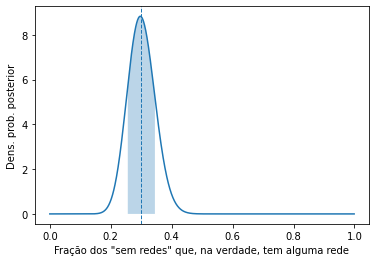

In [7]:
# Cálculo da probabilidade a posteriori da fração dos "sem rede" terem rede:
dp = 0.001
p, post = xx.triang_binom_posterior(0.7, n_semredes, n_redes_ocultas, dp)

# Cálculo do valor esperado e incerteza:
mean_p = (p * post * dp).sum()
mean_p2 = (p**2 * post * dp).sum()
dev_p = np.sqrt(mean_p2 - mean_p**2)
print('Fração dos "sem redes" que, na verdade, tem alguma rede: {:.3f} +/- {:.3f}'.format(mean_p, dev_p))

# Gráfico:
n_sigma = 1
pl.plot(p, post)
pl.axvline(mean_p, linestyle='--', linewidth=1)
pl.fill_between(p[(p > mean_p - n_sigma * dev_p) & (p < mean_p + n_sigma * dev_p)], post[(p > mean_p - n_sigma * dev_p) & (p < mean_p + n_sigma * dev_p)], alpha=0.3)
pl.xlabel('Fração dos "sem redes" que, na verdade, tem alguma rede')
pl.ylabel('Dens. prob. posterior')
pl.show()

### Estimativa do uso das diferentes plataformas

A partir das redes declaradas ao TSE e da estimativa de redes não declaradas acima, vamos estimar a verdadeira presença das diversas plataformas nas candidaturas. Para tanto, vamos assumir as seguintes hipóteses:

1. Que a fração de candidaturas com redes sociais entre as que não declararam nenhuma é dada pelo valor esperado estimado acima;
2. Que as plataformas não declaradas se distribuem da mesma maneira que as declaradas, isto é, que a suas presenças nas candidaturas são todas corrigidas por um fator constante.

In [8]:
# Corrigindo os dados de uso de redes sociais pela fração estimada de redes não declaradas:
cand_per_platform = use_df[redes_cols].sum()
NTs = cand_per_platform['nenhuma']
cand_per_platform.loc['nenhuma'] = cand_per_platform.loc['nenhuma'] * (1 - mean_p)
cand_per_platform.loc[cand_per_platform.index != 'nenhuma'] = cand_per_platform.loc[cand_per_platform.index != 'nenhuma'] * (1 + mean_p * NTs / (len(use_df) - NTs))

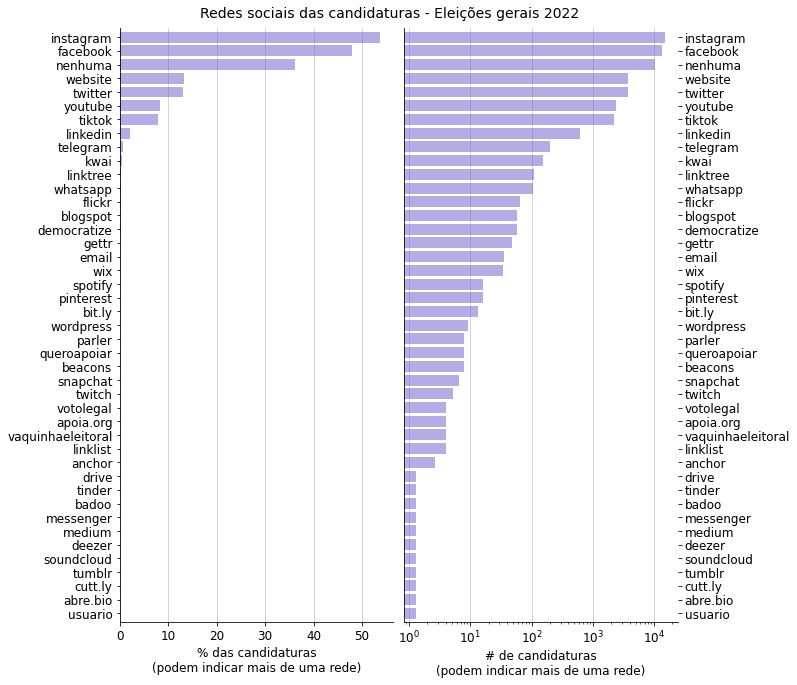

In [9]:
# Gráfico de uso das plataformas:
fig = af.plot_platform_counts(cand_per_platform, len(use_df), 'Eleições gerais 2022')
fig.savefig('plots/redes_sociais_das_candidaturas_2022.png')
pl.show()

Embora a hipótese 2 acima possa não ser exatamente válida, não acreditamos que uma eventual discrepância seja significativa a ponto de alterar a escala de grandeza da frequência de uso das diferentes plataformas. 

### Relação do uso de plataformas com dimensões dos candidatos

Vamos verificar como a declaração de cada plataforma está relacionada com as características dos candidatos.

#### Idade

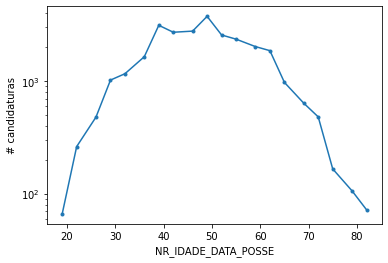

In [10]:
# Definindo os bins:
af.plot_bin_counts(use_df['NR_IDADE_DATA_POSSE'], 20, 18, 84)

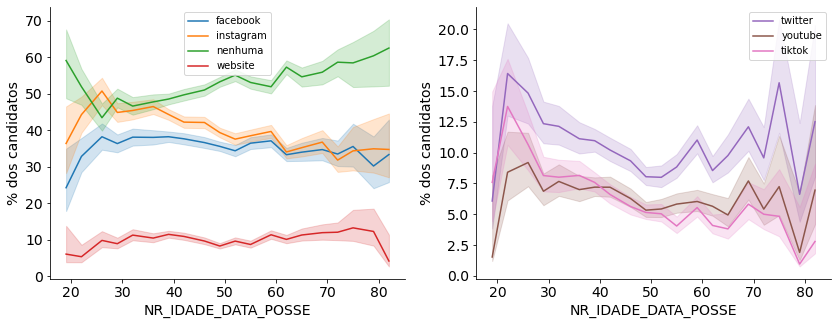

In [11]:
# Gráfico:
dim = 'NR_IDADE_DATA_POSSE'
n_bins = 20
lower_clip = 18
upper_clip = 84

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4)
pl.show()

#### Bens declarados

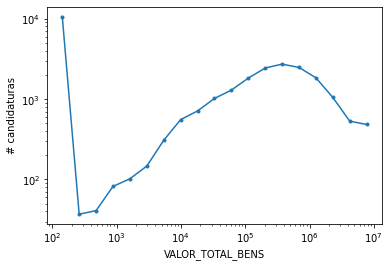

In [12]:
# Definindo os bins:
af.plot_bin_counts(use_df['VALOR_TOTAL_BENS'], 19, 101, 1e7, logscale=True)

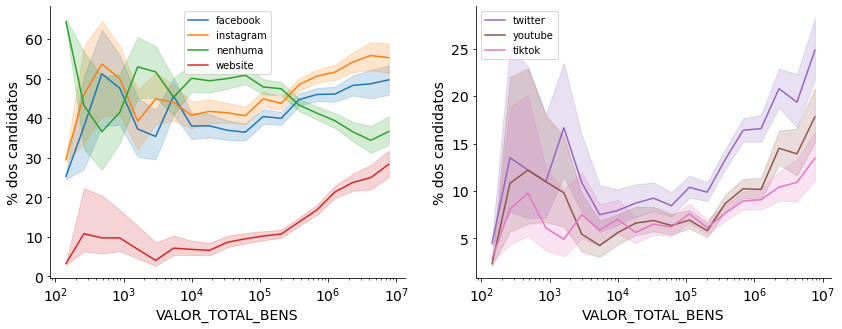

In [13]:
# Gráfico:
dim = 'VALOR_TOTAL_BENS'
n_bins = 19
lower_clip = 101
upper_clip = 1e7

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip, logscale=True)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4, logscale=True)
pl.show()

#### Quantidade de votos

No caso da quantidade de votos obtidos, os cargos aos quais os candidatos estão concorrendo pode distorcer a análise: cargos majoritários (senadores, presidentes, governadores) tendem a ter muito mais votos do que cargos proporcionais (deputados), mesmo se ponderarmos pelo tamanho do colégio eleitoral (para retirar efeitos de unidades com eleitorados de tamanhos muito diferentes). Por isso, faremos a análise apenas para deputados.

In [71]:
# Seleção dos deputados:
deps_use_df = use_df.loc[use_df['DS_CARGO'].isin(['DEPUTADO FEDERAL', 'DEPUTADO ESTADUAL', 'DEPUTADO DISTRITAL'])]

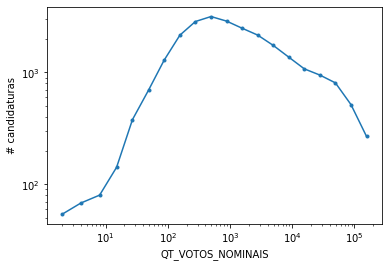

In [72]:
# Definindo os bins:
af.plot_bin_counts(deps_use_df['QT_VOTOS_NOMINAIS'], 20, 2, 2e5, logscale=True)

/home/skems/system/envs/ceweb/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


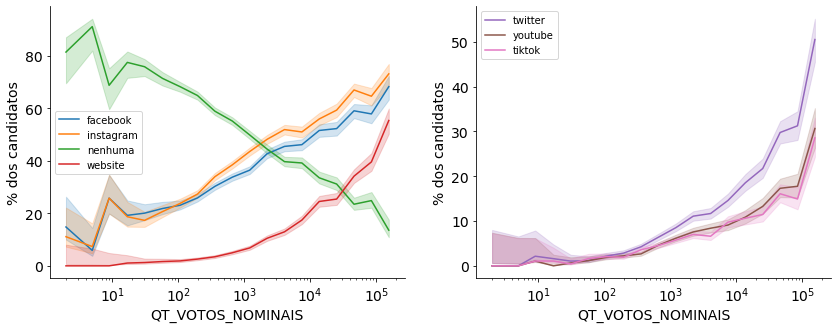

In [73]:
# Gráfico:
dim = 'QT_VOTOS_NOMINAIS'
n_bins = 19
lower_clip = 2
upper_clip = 2e5

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(deps_use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip, logscale=True)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(deps_use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4, logscale=True)
pl.show()

O resultado acima não compara os candidatos em termos de popularidade na sua unidade eleitoral, pois existem unidades com mais eleitores do que outras.
Para isolar esse efeito, vamos verificar o uso das plataformas em função de um número de eleitores de referência, de 100 milhões. 

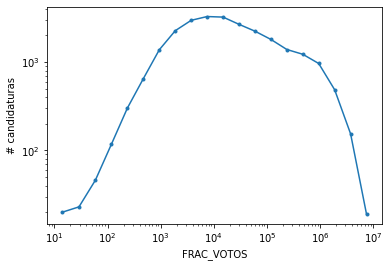

In [74]:
# Definindo os bins:
af.plot_bin_counts(deps_use_df['FRAC_VOTOS'], 20, 10, 1e7, logscale=True)

/home/skems/system/envs/ceweb/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


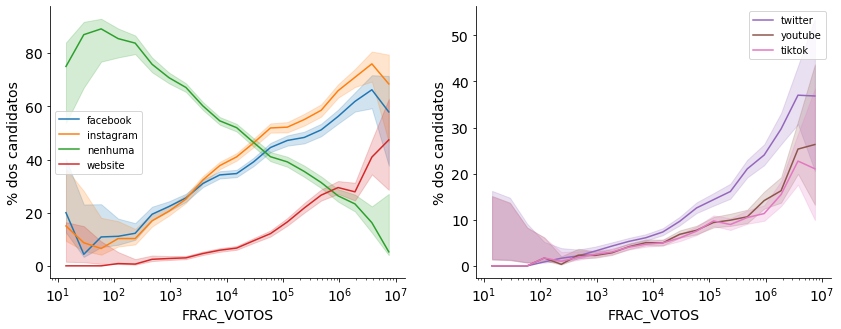

In [75]:
# Gráfico:
dim = 'FRAC_VOTOS'
n_bins = 20
lower_clip = 10
upper_clip = 1e7

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(deps_use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip, logscale=True)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(deps_use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4, logscale=True)
pl.show()

#### Cor/raça

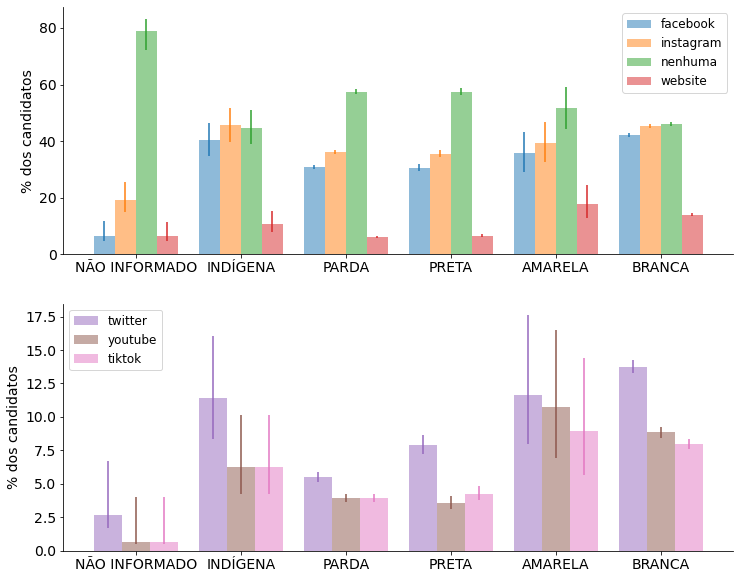

In [14]:
dim = 'DS_COR_RACA'
categories = ['NÃO INFORMADO', 'INDÍGENA', 'PARDA', 'PRETA', 'AMARELA', 'BRANCA']

pl.figure(figsize=(12, 10))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=12)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=12)
pl.show()

#### Gênero

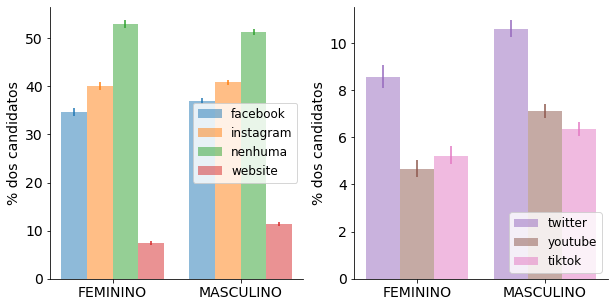

In [15]:
dim = 'DS_GENERO'
categories = ['FEMININO', 'MASCULINO']

pl.figure(figsize=(10, 5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=12, legend_loc='center right')
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=12, legend_loc='lower right')
pl.show()

#### Escolaridade

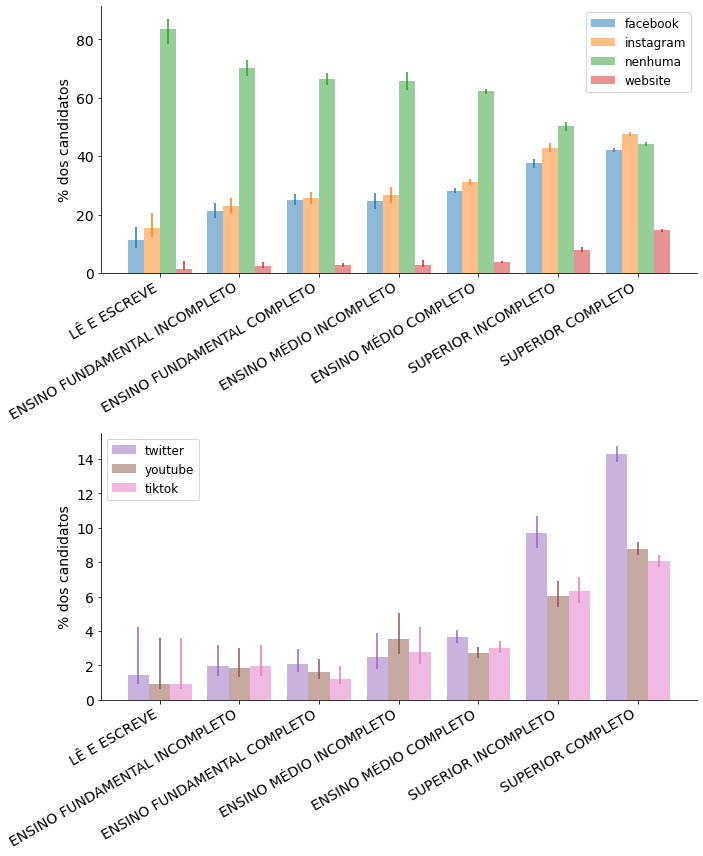

In [15]:
dim = 'DS_GRAU_INSTRUCAO'
categories = ['LÊ E ESCREVE', 'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO MÉDIO INCOMPLETO', 'ENSINO MÉDIO COMPLETO', 'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO']

pl.figure(figsize=(10, 12))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=12, label_rot=30)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=12, label_rot=30)
pl.tight_layout()
pl.show()

#### Cargo

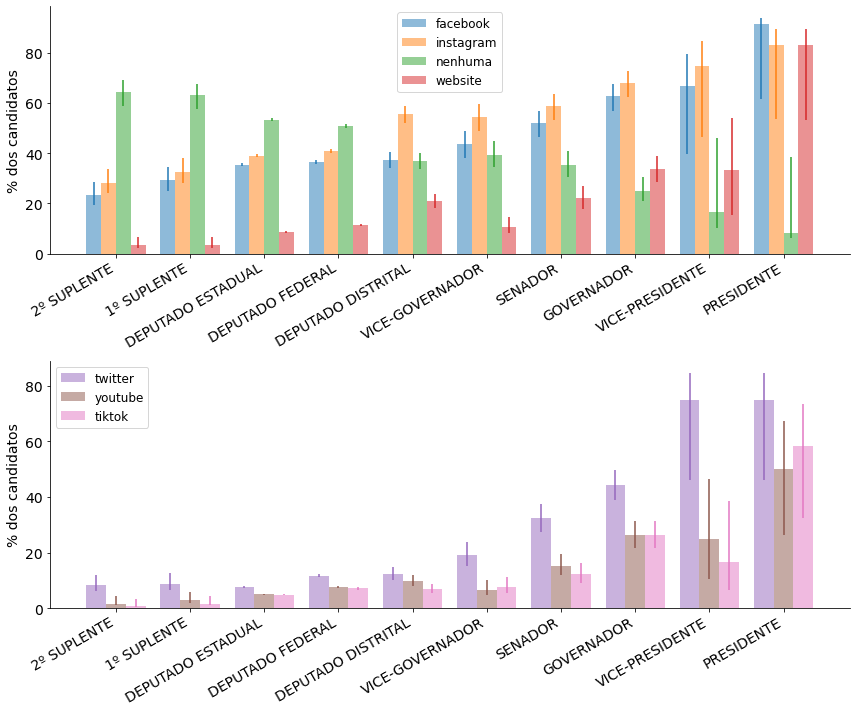

In [16]:
dim = 'DS_CARGO'
categories = ['2º SUPLENTE', '1º SUPLENTE', 'DEPUTADO ESTADUAL', 'DEPUTADO FEDERAL', 'DEPUTADO DISTRITAL', 'VICE-GOVERNADOR', 'SENADOR', 'GOVERNADOR', 'VICE-PRESIDENTE', 'PRESIDENTE']

pl.figure(figsize=(12, 10))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=12, label_rot=30)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=12, label_rot=30)
pl.tight_layout()
pl.show()